# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\lenovo\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [8]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
print("Data Points in Each class :")
print(filtered_data['Score'].value_counts()) 
filtered_data.head(3)

Number of data points in our data (525814, 10)
Data Points in Each class :
positive    443777
negative     82037
Name: Score, dtype: int64


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [10]:
#Sorting the data taking productid as the parameter
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data.shape

(525814, 10)

In [11]:
#Deleting the dublicates reviews which is created when user writed a review for the product, it automatically generates for the same product of different color etc
final = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [12]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [14]:
#Dropping the data which has HelpfulnessNumerator<HelpfulnessDenominator which is impossible
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

In [15]:
#Checking to see how much % of data still remains
print("Percentage of data still remains",(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100)

print("Final Data",final.shape)

Percentage of data still remains 69.25852107399194
Final Data (364171, 10)


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [2]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [17]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
from tqdm import tqdm
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in tqdm(final['Text'].values):
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

100%|█████████████████████████████████████████████████████████████████████████| 364171/364171 [09:24<00:00, 645.57it/s]


In [18]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
final.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...


In [19]:
final_data=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [21]:
final = final_data.head(100000)

In [4]:
X_train_data = final[:60000]
X_test_data = final[60000:100000]
y_train = X_train_data['Score']
y_test = X_test_data['Score']
print("Data")
print(X_train_data.shape)
print(X_test_data.shape)
print("Label")
print(y_train.shape)
print(y_test.shape)

Data
(60000, 11)
(40000, 11)
Label
(60000,)
(40000,)


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

# [4] Featurization

## [4.1] BAG OF WORDS

In [4]:
#BoW on Text
print("**Bow Vectorizer**")
print("="*50)
count_vect = CountVectorizer(min_df = 50)
X_train_BOW = count_vect.fit_transform(X_train_data['CleanedText'])
X_test_BOW = count_vect.transform(X_test_data['CleanedText'])
print(X_train_BOW.shape)
print(X_test_BOW.shape)

**Bow Vectorizer**
(60000, 2951)
(40000, 2951)


## [4.2] Bi-Grams and n-Grams.

In [26]:
# #bi-gram, tri-gram and n-gram

# #removing stop words like "not" should be avoided before building n-grams
# # count_vect = CountVectorizer(ngram_range=(1,2))
# # please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# # you can choose these numebrs min_df=10, max_features=5000, of your choice
# count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
# final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_bigram_counts))
# print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
# print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

## [4.3] TF-IDF

In [5]:
#TFIDF on Text
print("**TFIDF Vectorizer**")
print("="*50)
tf_idf_vect = TfidfVectorizer(min_df = 50)
X_train_tfidf = tf_idf_vect.fit_transform(X_train_data['CleanedText'])
X_test_tfidf = tf_idf_vect.transform(X_test_data['CleanedText'])
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

**TFIDF Vectorizer**
(60000, 2951)
(40000, 2951)


## [4.4] Word2Vec

In [18]:
# Traning W2VEC MODEL on Text Data

In [20]:
import gensim
i=0
list_of_sent_train=[]
for sent in tqdm(X_train_data['Text'].values):
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    # checking is the word is alphabet
                filtered_sentence.append(cleaned_words.lower()) # appending to the list
            else:
                continue 
    list_of_sent_train.append(filtered_sentence)

100%|██████████████████████████████████████████████████████████████████████████| 60000/60000 [00:18<00:00, 3265.41it/s]


In [21]:
import gensim
i=0
list_of_sent_test=[]
for sent in tqdm(X_test_data['Text'].values):
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    # checking is the word is alphabet
                filtered_sentence.append(cleaned_words.lower()) # appending to the list
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

100%|██████████████████████████████████████████████████████████████████████████| 40000/40000 [00:13<00:00, 2919.05it/s]


In [22]:
print(X_train_data['Text'].values[0])
print("*****************************************************************")
print(list_of_sent_train[0])

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
*****************************************************************
['this', 'witty', 'little', 'book', 'makes', 'my', 'son', 'laugh', 'at', 'loud', 'i', 'recite', 'it', 'in', 'the', 'car', 'as', 'were', 'driving', 'along', 'and', 'he', 'always', 'can', 'sing', 'the', 'refrain', 'hes', 'learned', 'about', 'whales', 'india', 'drooping', 'i', 'love', 'all', 'the', 'new', 'words', 'this', 'book', 'introduces', 'and', 'the', 'silliness', 'of', 'it', 'all', 'this', 'is', 'a', 'classic', 'book', 'i', 'am', 'willing', 'to', 'bet', 'my', 'son', 'will', 'still', 'be', 'able', 'to', 'recite', 'from', 'memory', 'when', 'he', 'is'

In [23]:
w2v_model=gensim.models.Word2Vec(list_of_sent_train,min_count=5,size=50, workers=6)

In [24]:
w2v_words = list(w2v_model.wv.vocab)
print(len(w2v_words))

14907


In [25]:
w2v_model.wv.most_similar('good')

[('great', 0.812552809715271),
 ('decent', 0.7698259353637695),
 ('fantastic', 0.747363805770874),
 ('yummy', 0.7164801359176636),
 ('fine', 0.707351565361023),
 ('bad', 0.7010976076126099),
 ('terrific', 0.6903871893882751),
 ('nice', 0.6729184985160828),
 ('amazing', 0.6685666441917419),
 ('tasty', 0.6685216426849365)]

In [26]:
w2v_model.wv.most_similar('tasty')

[('filling', 0.8337897658348083),
 ('yummy', 0.8115571737289429),
 ('satisfying', 0.8102364540100098),
 ('delicious', 0.8045182824134827),
 ('flavorful', 0.7210261821746826),
 ('moist', 0.7023195028305054),
 ('nutritious', 0.701299250125885),
 ('tastey', 0.697981595993042),
 ('healthy', 0.6820046901702881),
 ('dense', 0.6804293394088745)]

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [28]:
#TRAIN
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; 
for sent in tqdm(list_of_sent_train):
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec) 
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [03:48<00:00, 262.64it/s]


60000
50


In [29]:
#TEST
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; 
for sent in tqdm(list_of_sent_test):
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec) 
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 40000/40000 [02:53<00:00, 229.90it/s]


40000
50


#### [4.4.1.2] TFIDF weighted W2v

In [40]:
tfidf_vect = TfidfVectorizer(min_df = 50)
train_tfidf_w2v = tfidf_vect.fit_transform(X_train_data["CleanedText"])
test_tfidf_w2v = tfidf_vect.transform(X_test_data["CleanedText"])
dictionary = dict(zip(tfidf_vect.get_feature_names(), list(tfidf_vect.idf_)))
print(train_tfidf_w2v.shape)
print(test_tfidf_w2v.shape)

(60000, 2951)
(40000, 2951)


In [41]:
# TF-IDF weighted Word2Vec
tfidf_feat = tfidf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [07:48<00:00, 128.18it/s]


In [42]:
# TF-IDF weighted Word2Vec
tfidf_feat = tfidf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 40000/40000 [05:33<00:00, 119.81it/s]


# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

In [7]:
# Importing libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
# Importing libraries for accuracy metrics
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_auc_score
import scikitplot as skplt

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [14]:
#Standardising the train and test data
sc = StandardScaler(copy=True, with_mean=False, with_std=True)
X_train = sc.fit_transform(X_train_BOW)
X_test = sc.transform(X_test_BOW)

In [22]:
tuned_parameters = [10**-4, 10**-2, 10**0, 10**2, 10**4]

# empty list cv_scores that will hold cross-validation scores
cv_scores = []

# performing 3-fold cross validation on train data
for i in tqdm(tuned_parameters):
    model = LogisticRegression(penalty='l1', C=i, n_jobs=-1)
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='roc_auc', n_jobs=-1)
    cv_scores.append(scores.mean()) 

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 26.52s/it]



The optimal value of C is 0.010.


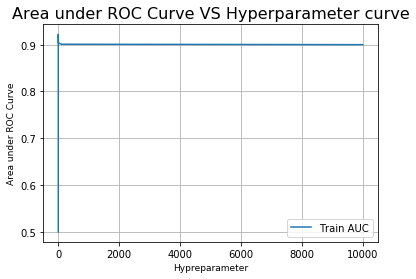

In [23]:
# determining best value of alpha
optimal_C = tuned_parameters[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of C is %.3f.' % optimal_C)
# plot accuracy vs alpha 
plt.plot(tuned_parameters, cv_scores,label="Train AUC")
plt.xlabel('Hypreparameter',size=9)
plt.ylabel('Area under ROC Curve',size=9)
plt.title('Area under ROC Curve VS Hyperparameter curve',size=16)
plt.legend(loc='best')
plt.grid()
plt.show()

***Test Data Report***
Best C =  0.01
AUC =  92.79517513159695


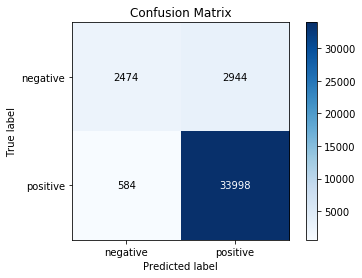

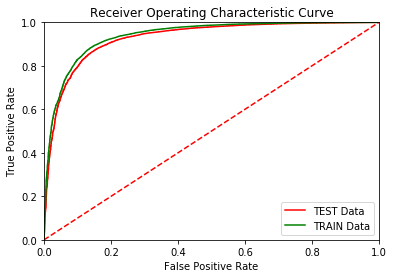

In [24]:
# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
lr.fit(X_train,y_train)
pred = lr.predict(X_test)


print("***Test Data Report***")
print("Best C = ",optimal_C)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:,1],pos_label="positive")
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()



fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:,1],pos_label="positive")
fpr2, tpr2, threshold2 = metrics.roc_curve(y_train, lr.predict_proba(X_train)[:,1],pos_label="positive")

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic Curve')
plt.gca().set_color_cycle(['red', 'green'])
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [3]:
# Please write all the code with proper documentation

In [90]:
w = lr.coef_
print("Sparsity on Weight Vector = ",np.count_nonzero(w))

Sparsity on Weight Vector =  844


In [91]:
# Sparsity with change in Hyperparameter
hyperparameter = [10**0, 10**-1, 10**-2, 10**-3, 10**-4, 10**-5];
sparsity = []
performance = []
# Storing for using ploting it later 

In [92]:
for i in hyperparameter:
    model = LogisticRegression(C=i, penalty='l1');
    model.fit(X_test, y_test);
    weight = model.coef_
    sparsity.append(np.count_nonzero(weight))

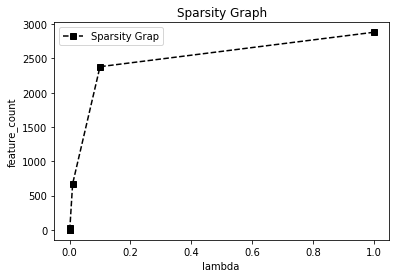

C =  [1, 0.1, 0.01, 0.001, 0.0001, 1e-05]
sparsity =  [2882, 2380, 671, 27, 0, 0]


In [94]:
#plotting the the Sparsity graph
plt.plot(hyperparameter, sparsity, 'ks--',label='Sparsity Grap')
plt.xlabel('lambda ')
plt.ylabel('feature_count')
plt.title("Sparsity Graph")
plt.legend()
plt.show()
print("C = ",hyperparameter)
print("sparsity = ",sparsity)

- > From above plot it is clear that c is directly proportional to Sparsity i.e when C is decresing then no. of non zero element in the weights of the model is also decresing

### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [32]:
tuned_parameters = [10**-4, 10**-2, 10**0, 10**2, 10**4]

# empty list cv_scores that will hold cross-validation scores
cv_scores = []

# performing 3-fold cross validation on train data
for i in tqdm(tuned_parameters):
    model = LogisticRegression(penalty='l2', C=i, n_jobs=-1)
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='roc_auc', n_jobs=-1)
    cv_scores.append(scores.mean()) 

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:22<00:00, 18.01s/it]



The optimal value of C is 0.010.


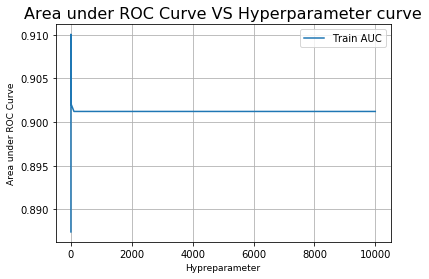

In [33]:
# determining best value of alpha
optimal_C = tuned_parameters[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of C is %.3f.' % optimal_C)
# plot accuracy vs alpha 
plt.plot(tuned_parameters, cv_scores,label="Train AUC")
plt.xlabel('Hypreparameter',size=9)
plt.ylabel('Area under ROC Curve',size=9)
plt.title('Area under ROC Curve VS Hyperparameter curve',size=16)
plt.legend(loc='best')
plt.grid()
plt.show()

***Test Data Report***
Best C =  0.01
AUC =  91.76137925364569


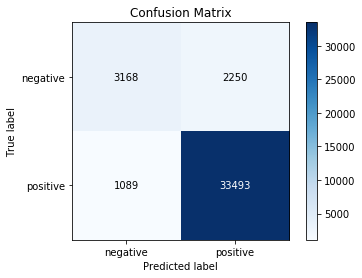

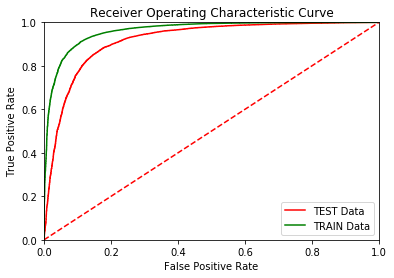

In [34]:
# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
lr.fit(X_train,y_train)
pred = lr.predict(X_test)
w = lr.coef_


print("***Test Data Report***")
print("Best C = ",optimal_C)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:,1],pos_label="positive")
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()



fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:,1],pos_label="positive")
fpr2, tpr2, threshold2 = metrics.roc_curve(y_train, lr.predict_proba(X_train)[:,1],pos_label="positive")

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic Curve')
plt.gca().set_color_cycle(['red', 'green'])
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [35]:
X_train.data = X_train.data + 0.01; #adding a small value to each weight of train data
print(X_train.shape)
print(X_test.shape)
# Adding a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse matrix, X.data+=e)

(60000, 2951)
(40000, 2951)


In [36]:
# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
lr.fit(X_train,y_train)
pred = lr.predict(X_test)

w_dash = lr.coef_
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:,1],pos_label="positive")
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)

AUC =  91.75882541864372


In [39]:
w = w[0] + 0.000001;
w_dash = w_dash[0] +0.000001;
W = list(w)
W_Dash = list(w_dash)

In [44]:
#finding % change between W and W' (| (W-W') / (W) |)*100)
change_percentage = []
# count = 0;
for i in tqdm(range(0,len(W))):
    change = 0
    change=(abs((W[i]-(W_Dash[i]))/(W[i])))*100
    change_percentage.append(change)

100%|██████████████████████████████████████████████████████████████████████████| 2951/2951 [00:00<00:00, 421444.08it/s]


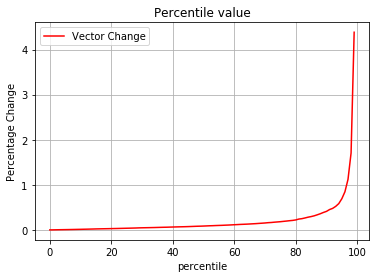

In [89]:
# Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector
percentile_value = []
percentile = []
i = 0
while i < 100:
    percentile.append(i)
    percentile_value.append(np.percentile(change_percentage,i))
    i+=1;
    
# percentile_value_change_plot
plt.plot(percentile, percentile_value, 'r',label='Vector Change')
plt.xlabel('percentile')
plt.ylabel('Percentage Change')
plt.title("Percentile value")
plt.legend(loc = 'best')
plt.grid()
plt.show()

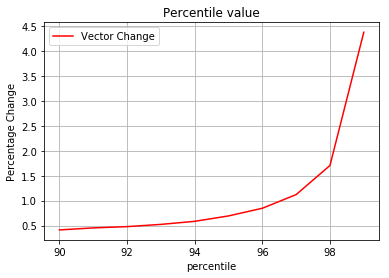

In [90]:
# Calculating 90 to 100 percentile
percentile_value = []
percentile = []
i = 90
while i < 100:
    percentile.append(i)
    percentile_value.append(np.percentile(change_percentage,i))
    i+=1;
    
# percentile_value_change_plot
plt.plot(percentile, percentile_value, 'r',label='Vector Change')
plt.xlabel('percentile')
plt.ylabel('Percentage Change')
plt.title("Percentile value")
plt.legend(loc = 'best')
plt.grid()
plt.show()

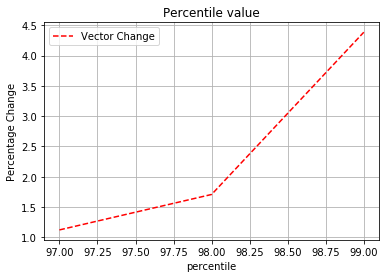

In [93]:
#Calculating 98 to 100 percentile
percentile_value = []
percentile = []
i = 97
while i < 100:
    percentile.append(i)
    percentile_value.append(np.percentile(change_percentage,i))
    i+=1;
    
# percentile_value_change_plot
plt.plot(percentile, percentile_value, 'r--',label='Vector Change')
plt.xlabel('percentile')
plt.ylabel('Percentage Change')
plt.title("Percentile value")
plt.legend(loc = 'best')
plt.grid()
plt.show()

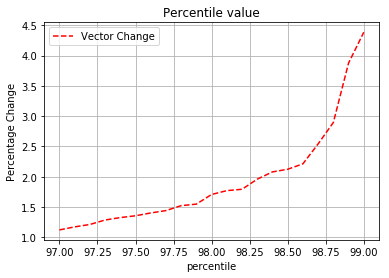

In [103]:
#Calculating 98 to 100 percentile
percentile_value = []
percentile = []
i = 97
while i < 99:
    percentile.append(i)
    percentile_value.append(np.percentile(change_percentage,i))
    i+=0.1;
    
# percentile_value_change_plot
plt.plot(percentile, percentile_value, 'r--',label='Vector Change')
plt.xlabel('percentile')
plt.ylabel('Percentage Change')
plt.title("Percentile value")
plt.legend(loc = 'best')
plt.grid()
plt.show()

In [ ]:
# 97.9 elbow finded out and the threshold value is approx 1.5

In [107]:
#w_with_greater_than_thresold = []
# temp_weight = list(w[0])
feature_names = count_vect.get_feature_names() #getting all feature name
feature_above_threshold = []
number_of_points_above_threshold = 0;
for i in range(0,len(change_percentage)):
    if change_percentage[i] > 1.5:
        number_of_points_above_threshold += 1;
        feature_above_threshold.append(feature_names[i])
        
print("Number_of_points_above_threshold = ",number_of_points_above_threshold)
print("="*50)
print("*Feature_Name_above_threshold* = ",feature_above_threshold)

Number_of_points_above_threshold =  66
*Feature_Name_above_threshold* =  ['african', 'anywher', 'appear', 'around', 'awhil', 'bar', 'basil', 'birthday', 'boneless', 'browni', 'buck', 'buttermilk', 'charm', 'chocol', 'cider', 'cocoa', 'come', 'content', 'crumb', 'cube', 'cute', 'degre', 'depart', 'detail', 'dill', 'doubt', 'douw', 'dust', 'egbert', 'espresso', 'extend', 'face', 'freez', 'genuin', 'glaze', 'gone', 'greek', 'heard', 'helper', 'hint', 'izz', 'latter', 'lost', 'marinad', 'medium', 'met', 'miso', 'mix', 'peppermint', 'pitcher', 'pomegran', 'possibl', 'price', 'quaker', 'recycl', 'regret', 'reus', 'seem', 'shortbread', 'slip', 'snap', 'suitabl', 'sweeter', 'tonight', 'vitamin', 'walmart']


### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [61]:
feature_name = count_vect.get_feature_names()
w = lr.coef_
weight=w.reshape(-1)
sorted_feature = np.argsort(weight)
top_20_positive_feature=sorted_feature[:-20:-1]

In [62]:
print("Positive feature top 20 :")
print("-------")
for i in top_20_positive_feature:
    print("%s\t-->\t%f"%(feature_name[i],weight[i]))

Positive feature top 20 :
-------
great	-->	0.618346
best	-->	0.425758
love	-->	0.414430
delici	-->	0.393084
perfect	-->	0.329481
excel	-->	0.291387
good	-->	0.279891
nice	-->	0.244752
wonder	-->	0.201069
favorit	-->	0.196634
amaz	-->	0.163595
tasti	-->	0.158833
easi	-->	0.144312
alway	-->	0.140255
use	-->	0.136088
keep	-->	0.135085
happi	-->	0.133365
smooth	-->	0.131975
find	-->	0.131351


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [63]:
# Please write all the code with proper documentation

In [66]:
w = lr.coef_
weight=w.reshape(-1)
sorted_feature = np.argsort(weight)
feature_name = count_vect.get_feature_names()
top_20_negative_feature = sorted_feature[:20]

In [67]:
print("Negative feature top 20 :")
print("-------")
for i in top_20_negative_feature:
    print("%s\t -->\t%f  "%(feature_name[i],weight[i]))

Negative feature top 20 :
-------
disappoint	 -->	-0.265422  
worst	 -->	-0.189404  
terribl	 -->	-0.147469  
aw	 -->	-0.138405  
return	 -->	-0.131647  
unfortun	 -->	-0.131053  
horribl	 -->	-0.130007  
bland	 -->	-0.127723  
money	 -->	-0.125601  
product	 -->	-0.124492  
bad	 -->	-0.124103  
thought	 -->	-0.121510  
tast	 -->	-0.121337  
threw	 -->	-0.110799  
stale	 -->	-0.107298  
would	 -->	-0.103874  
weak	 -->	-0.099874  
mayb	 -->	-0.097448  
sorri	 -->	-0.096320  
wast	 -->	-0.094691  


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [8]:
sc = StandardScaler(copy=True, with_mean=False, with_std=True)
X_train = sc.fit_transform(X_train_tfidf)
X_test = sc.transform(X_test_tfidf)

In [9]:
tuned_parameters = [10**-4, 10**-2, 10**0, 10**2, 10**4]

# empty list cv_scores that will hold cross-validation scores
cv_scores = []

# performing 3-fold cross validation on train data
for i in tqdm(tuned_parameters):
    model = LogisticRegression(penalty='l1', C=i, n_jobs=-1)
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='roc_auc', n_jobs=-1)
    cv_scores.append(scores.mean()) 

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:54<00:00, 11.46s/it]



The optimal value of C is 0.010.


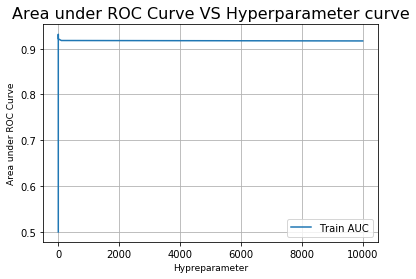

In [10]:
# determining best value of alpha
optimal_C = tuned_parameters[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of C is %.3f.' % optimal_C)
# plot accuracy vs alpha 
plt.plot(tuned_parameters, cv_scores,label="Train AUC")
plt.xlabel('Hypreparameter',size=9)
plt.ylabel('Area under ROC Curve',size=9)
plt.title('Area under ROC Curve VS Hyperparameter curve',size=16)
plt.legend(loc='best')
plt.grid()
plt.show()

***Test Data Report***
Best C =  0.01
AUC =  93.84564805914198


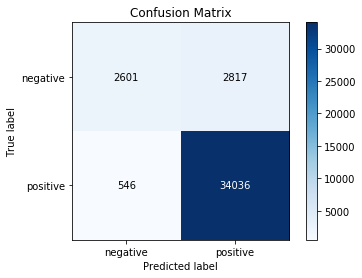

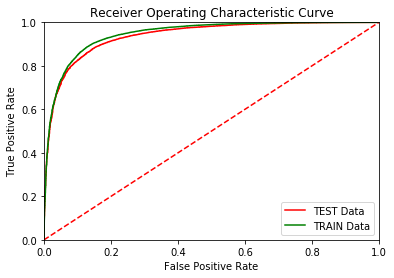

In [11]:
# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
lr.fit(X_train,y_train)
pred = lr.predict(X_test)
w = lr.coef_


print("***Test Data Report***")
print("Best C = ",optimal_C)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:,1],pos_label="positive")
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()



fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:,1],pos_label="positive")
fpr2, tpr2, threshold2 = metrics.roc_curve(y_train, lr.predict_proba(X_train)[:,1],pos_label="positive")

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic Curve')
plt.gca().set_color_cycle(['red', 'green'])
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [3]:
# Please write all the code with proper documentation

In [12]:
tuned_parameters = [10**-4, 10**-2, 10**0, 10**2, 10**4]

# empty list cv_scores that will hold cross-validation scores
cv_scores = []

# performing 3-fold cross validation on train data
for i in tqdm(tuned_parameters):
    model = LogisticRegression(penalty='l2', C=i, n_jobs=-1)
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='roc_auc', n_jobs=-1)
    cv_scores.append(scores.mean()) 

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:23<00:00, 18.22s/it]



The optimal value of C is 0.010.


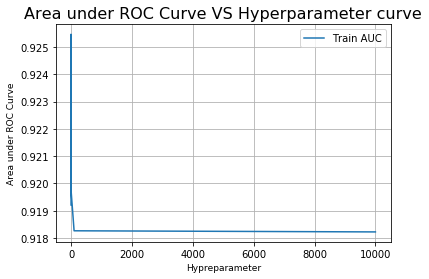

In [13]:
# determining best value of alpha
optimal_C = tuned_parameters[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of C is %.3f.' % optimal_C)
# plot accuracy vs alpha 
plt.plot(tuned_parameters, cv_scores,label="Train AUC")
plt.xlabel('Hypreparameter',size=9)
plt.ylabel('Area under ROC Curve',size=9)
plt.title('Area under ROC Curve VS Hyperparameter curve',size=16)
plt.legend(loc='best')
plt.grid()
plt.show()

***Test Data Report***
Best C =  0.01
AUC =  93.21478943622404


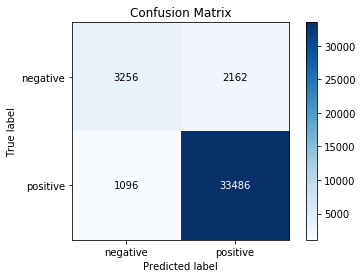

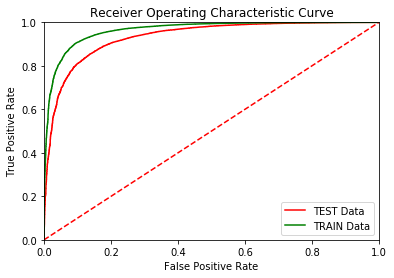

In [14]:
# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
lr.fit(X_train,y_train)
pred = lr.predict(X_test)
w = lr.coef_


print("***Test Data Report***")
print("Best C = ",optimal_C)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:,1],pos_label="positive")
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()



fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:,1],pos_label="positive")
fpr2, tpr2, threshold2 = metrics.roc_curve(y_train, lr.predict_proba(X_train)[:,1],pos_label="positive")

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic Curve')
plt.gca().set_color_cycle(['red', 'green'])
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [15]:
feature_name = count_vect.get_feature_names()
w = lr.coef_
weight=w.reshape(-1)
sorted_feature = np.argsort(weight)
top_20_positive_feature=sorted_feature[:-20:-1]

In [16]:
print("Positive feature top 20 :")
print("-------")
for i in top_20_positive_feature:
    print("%s\t-->\t%f"%(feature_name[i],weight[i]))

Positive feature top 20 :
-------
great	-->	0.790430
love	-->	0.576829
best	-->	0.567701
delici	-->	0.455670
perfect	-->	0.414097
excel	-->	0.397636
good	-->	0.385577
nice	-->	0.310070
favorit	-->	0.279265
wonder	-->	0.275742
amaz	-->	0.255054
addict	-->	0.238393
awesom	-->	0.231547
tasti	-->	0.227272
find	-->	0.215908
smooth	-->	0.211668
yummi	-->	0.196880
easi	-->	0.187746
happi	-->	0.179560


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [18]:
weight=w.reshape(-1)
sorted_feature = np.argsort(weight)
feature_name = tf_idf_vect.get_feature_names()
top_20_negative_feature = sorted_feature[:20]

In [19]:
print("Negative feature top 20 :")
print("-------")
for i in top_20_negative_feature:
    print("%s\t -->\t%f  "%(feature_name[i],weight[i]))

Negative feature top 20 :
-------
disappoint	 -->	-0.268877  
worst	 -->	-0.263415  
terribl	 -->	-0.167024  
aw	 -->	-0.166730  
tast	 -->	-0.155812  
bland	 -->	-0.151842  
money	 -->	-0.143596  
return	 -->	-0.141761  
horribl	 -->	-0.134992  
stale	 -->	-0.131496  
unfortun	 -->	-0.130925  
weak	 -->	-0.126315  
thought	 -->	-0.123551  
threw	 -->	-0.120708  
sorri	 -->	-0.117631  
unpleas	 -->	-0.116272  
away	 -->	-0.114170  
noth	 -->	-0.112924  
mayb	 -->	-0.112416  
bad	 -->	-0.111092  


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [30]:
#Standardising the train and test data
sc = StandardScaler()
X_train = sc.fit_transform(sent_vectors_train)
X_test = sc.transform(sent_vectors_test)

In [31]:
tuned_parameters = [10**-4, 10**-2, 10**0, 10**2, 10**4]

# empty list cv_scores that will hold cross-validation scores
cv_scores = []

# performing 10-fold cross validation on train data
for i in tqdm(tuned_parameters):
    model = LogisticRegression(penalty='l1', C=i, n_jobs=-1)
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='roc_auc', n_jobs=-1)
    cv_scores.append(scores.mean()) 

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:01<00:00, 64.92s/it]



The optimal value of alpha is 1.000.


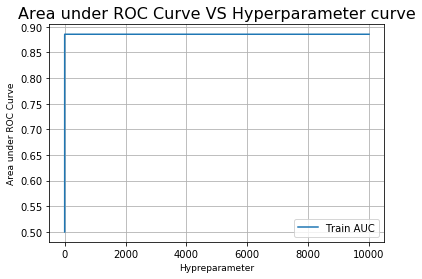

In [32]:
# determining best value of alpha
optimal_C = tuned_parameters[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of alpha is %.3f.' % optimal_C)
# plot accuracy vs alpha 
plt.plot(tuned_parameters, cv_scores,label="Train AUC")
plt.xlabel('Hypreparameter',size=9)
plt.ylabel('Area under ROC Curve',size=9)
plt.title('Area under ROC Curve VS Hyperparameter curve',size=16)
plt.legend(loc='best')
plt.grid()
plt.show()

***Test Data Report***
Best C =  1
AUC =  93.21478943622404


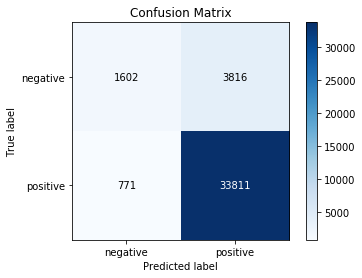

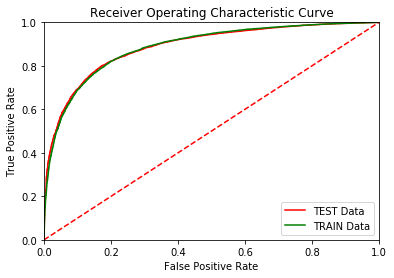

In [33]:
# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
lr.fit(X_train,y_train)
pred = lr.predict(X_test)


print("***Test Data Report***")
print("Best C = ",optimal_C)
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()



fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:,1],pos_label="positive")
fpr2, tpr2, threshold2 = metrics.roc_curve(y_train, lr.predict_proba(X_train)[:,1],pos_label="positive")

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic Curve')
plt.gca().set_color_cycle(['red', 'green'])
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [37]:
tuned_parameters = [10**-4, 10**-2, 10**0, 10**2, 10**4]

# empty list cv_scores that will hold cross-validation scores
cv_scores = []

# performing 10-fold cross validation on train data
for i in tqdm(tuned_parameters):
    model = LogisticRegression(penalty='l2', C=i, n_jobs=-1)
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='roc_auc', n_jobs=-1)
    cv_scores.append(scores.mean()) 

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.17s/it]



The optimal value of alpha is 1.000.


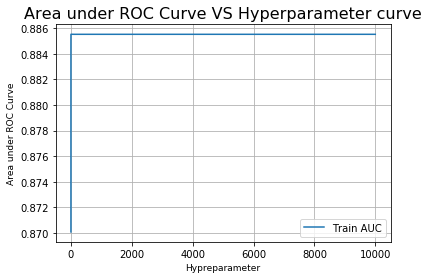

In [38]:
# determining best value of alpha
optimal_C = tuned_parameters[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of alpha is %.3f.' % optimal_C)
# plot accuracy vs alpha 
plt.plot(tuned_parameters, cv_scores,label="Train AUC")
plt.xlabel('Hypreparameter',size=9)
plt.ylabel('Area under ROC Curve',size=9)
plt.title('Area under ROC Curve VS Hyperparameter curve',size=16)
plt.legend(loc='best')
plt.grid()
plt.show()

***Test Data Report***
Best C =  1
AUC =  88.79468520090136


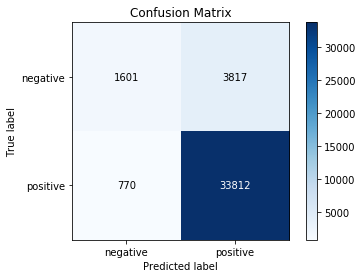

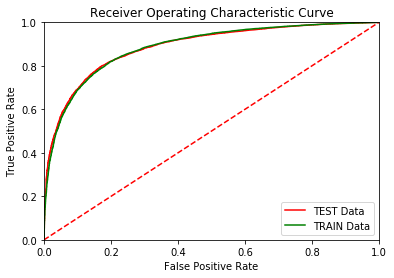

In [39]:
# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
lr.fit(X_train,y_train)
pred = lr.predict(X_test)


print("***Test Data Report***")
print("Best C = ",optimal_C)
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()



fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:,1],pos_label="positive")
fpr2, tpr2, threshold2 = metrics.roc_curve(y_train, lr.predict_proba(X_train)[:,1],pos_label="positive")

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic Curve')
plt.gca().set_color_cycle(['red', 'green'])
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [79]:
#Standardising the train and test data
sc = StandardScaler(copy=True, with_mean=False, with_std=True)
X_train = sc.fit_transform(tfidf_sent_vectors_train)
X_test = sc.transform(tfidf_sent_vectors_test)

In [80]:
tuned_parameters = [10**-4, 10**-2, 10**0, 10**2, 10**4]

# empty list cv_scores that will hold cross-validation scores
cv_scores = []

# performing 10-fold cross validation on train data
for i in tqdm(tuned_parameters):
    model = LogisticRegression(penalty='l1', C=i, n_jobs=-1)
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='roc_auc', n_jobs=-1)
    cv_scores.append(scores.mean()) 

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:21<00:00, 43.29s/it]



The optimal value of alpha is 100.000.


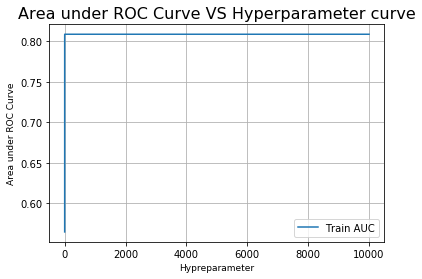

In [81]:
# determining best value of alpha
optimal_C = tuned_parameters[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of alpha is %.3f.' % optimal_C)
# plot accuracy vs alpha 
plt.plot(tuned_parameters, cv_scores,label="Train AUC")
plt.xlabel('Hypreparameter',size=9)
plt.ylabel('Area under ROC Curve',size=9)
plt.title('Area under ROC Curve VS Hyperparameter curve',size=16)
plt.legend(loc='best')
plt.grid()
plt.show()

***Test Data Report***
Best C =  100
AUC =  81.41704709468152


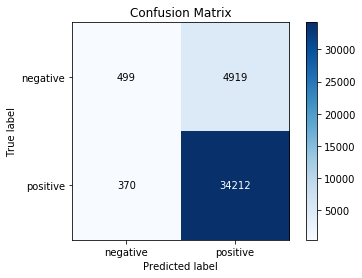

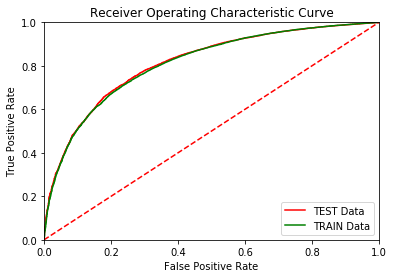

In [82]:
# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
lr.fit(X_train,y_train)
pred = lr.predict(X_test)


print("***Test Data Report***")
print("Best C = ",optimal_C)
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()



fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:,1],pos_label="positive")
fpr2, tpr2, threshold2 = metrics.roc_curve(y_train, lr.predict_proba(X_train)[:,1],pos_label="positive")

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic Curve')
plt.gca().set_color_cycle(['red', 'green'])
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [83]:
tuned_parameters = [10**-4, 10**-2, 10**0, 10**2, 10**4]

# empty list cv_scores that will hold cross-validation scores
cv_scores = []

# performing 10-fold cross validation on train data
for i in tqdm(tuned_parameters):
    model = LogisticRegression(penalty='l2', C=i, n_jobs=-1)
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='roc_auc', n_jobs=-1)
    cv_scores.append(scores.mean()) 

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:35<00:00,  7.10s/it]



The optimal value of alpha is 100.000.


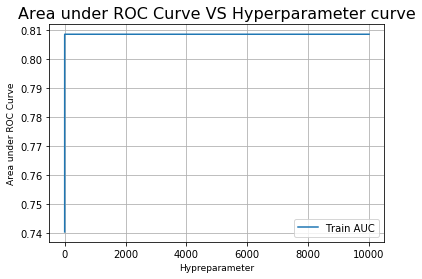

In [84]:
# determining best value of alpha
optimal_C = tuned_parameters[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of alpha is %.3f.' % optimal_C)
# plot accuracy vs alpha 
plt.plot(tuned_parameters, cv_scores,label="Train AUC")
plt.xlabel('Hypreparameter',size=9)
plt.ylabel('Area under ROC Curve',size=9)
plt.title('Area under ROC Curve VS Hyperparameter curve',size=16)
plt.legend(loc='best')
plt.grid()
plt.show()

***Test Data Report***
Best C =  100
AUC =  81.41716611353321


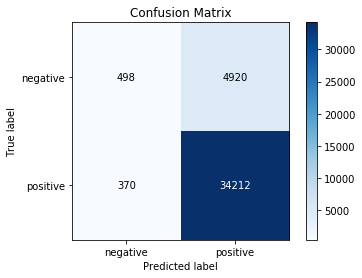

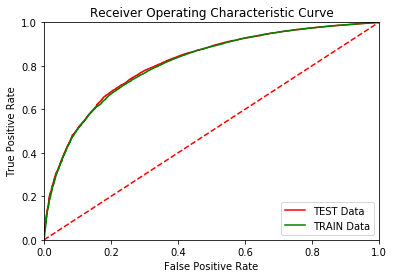

In [85]:
# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
lr.fit(X_train,y_train)
pred = lr.predict(X_test)


print("***Test Data Report***")
print("Best C = ",optimal_C)
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()



fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:,1],pos_label="positive")
fpr2, tpr2, threshold2 = metrics.roc_curve(y_train, lr.predict_proba(X_train)[:,1],pos_label="positive")

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic Curve')
plt.gca().set_color_cycle(['red', 'green'])
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# [6] Conclusions

In [86]:
#importing library
from prettytable import PrettyTable
x = PrettyTable()

#adding Field names
x.field_names = ["SL No.","Vectorizer","Regularization","Hypreparameter(C)" ,"AUC"]

# adding row to table
x.add_row(["1","BOW","L1",0.01,92.7952])
x.add_row(["2","BOW","L2",0.01,91.7614])
x.add_row(["3","TFIDF","L1",0.01,93.8456])
x.add_row(["4","TFIDF","L2",0.01,93.2148])
x.add_row(["5","Avg-W2vec","L1",1,93.2148])
x.add_row(["6","Avg-W2vec","L2",1,88.7947])
x.add_row(["7","TFIDF-W2vec","L1",100,81.4170])
x.add_row(["8","TFIDF-W2vec","L2",100,81.4146])

#printing the table
print(x)

+--------+-------------+----------------+-------------------+---------+
| SL No. |  Vectorizer | Regularization | Hypreparameter(C) |   AUC   |
+--------+-------------+----------------+-------------------+---------+
|   1    |     BOW     |       L1       |        0.01       | 92.7952 |
|   2    |     BOW     |       L2       |        0.01       | 91.7614 |
|   3    |    TFIDF    |       L1       |        0.01       | 93.8456 |
|   4    |    TFIDF    |       L2       |        0.01       | 93.2148 |
|   5    |  Avg-W2vec  |       L1       |         1         | 93.2148 |
|   6    |  Avg-W2vec  |       L2       |         1         | 88.7947 |
|   7    | TFIDF-W2vec |       L1       |        100        |  81.417 |
|   8    | TFIDF-W2vec |       L2       |        100        | 81.4146 |
+--------+-------------+----------------+-------------------+---------+


### OBSERVATION
- > BOW and TFIDF vectorizer model version of Logistic regression is more accurate as compared to Avg W2VEC andTFIDF AVGW2VEC
- > TFIDF W2VEC performs worst as compared to the four models and BOW model works best out there